<a href="https://colab.research.google.com/github/Daalleee/Klasifikasi-kematangan-buah-pepaya/blob/main/pemrosesanCitra_Buah_Pepaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

Pertama, kita perlu menghubungkan ke Google Drive untuk mengakses dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Persiapan dan Import Library


In [3]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import cv2
from collections import Counter
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

## 1. Analisis Dataset Awal



In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt # Added for visualization

# Define paths - Please update this path to match your dataset location in Google Drive
data_dir = '/content/drive/MyDrive/data'  # Update this path to your dataset location
classes = ['mentah', 'setengah', 'matang']

# Check if dataset directory exists
if os.path.exists(data_dir):
    print(f" Direktori dataset ditemukan: {data_dir}")

    # Check each class directory
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            print(f" Kelas '{class_name}' ditemukan")
        else:
            print(f"   Kelas '{class_name}' TIDAK DITEMUKAN")
            print(f"   Periksa apakah folder '{class_name}' ada di {data_dir}")
else:
    print(f"  Direktori dataset TIDAK DITEMUKAN: {data_dir}")
    print("   Silakan periksa kembali path dataset Anda")
    print("   Contoh: '/content/drive/MyDrive/nama_folder_dataset_anda'")

# Count images in each class before preprocessing and augmentation
def count_images_per_class(data_dir, classes):
    counts = {}
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            counts[class_name] = len(os.listdir(class_path))
        else:
            counts[class_name] = 0
    return counts

initial_counts = count_images_per_class(data_dir, classes)
total_initial = sum(initial_counts.values())

print("\nJumlah citra per kelas sebelum augmentasi:")
for class_name, count in initial_counts.items():
    print(f"  {class_name}: {count} citra")
print(f"Total citra awal: {total_initial}")

 Direktori dataset ditemukan: /content/drive/MyDrive/data
 Kelas 'mentah' ditemukan
 Kelas 'setengah' ditemukan
 Kelas 'matang' ditemukan

Jumlah citra per kelas sebelum augmentasi:
  mentah: 11 citra
  setengah: 11 citra
  matang: 11 citra
Total citra awal: 33


## 2. Preprocessing Citra

### Proses Pra-pemrosesan



In [13]:
# Function to preprocess image (from your original code with enhancements)
def preprocess_image(image_path):
    """Fungsi untuk melakukan pra-pemrosesan pada citra"""
    # Baca citra
    img = cv2.imread(image_path)

    # Resize citra ke ukuran 224x224
    img_resized = cv2.resize(img, (224, 224))

    # Terapkan filter Gaussian untuk mengurangi noise
    img_filtered = cv2.GaussianBlur(img_resized, (5, 5), 0)

    # Konversi ke ruang warna HSV untuk segmentasi
    hsv = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2HSV)

    # Thresholding sederhana untuk memisahkan papaya dari latar belakang
    # Rentang HSV ini bisa disesuaikan tergantung warna dominan papaya
    lower_hsv = np.array([0, 20, 20])
    upper_hsv = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # Terapkan mask untuk mendapatkan citra yang disegmentasi
    segmented = cv2.bitwise_and(img_filtered, img_filtered, mask=mask)

    return segmented

### Contoh Hasil Preprocessing



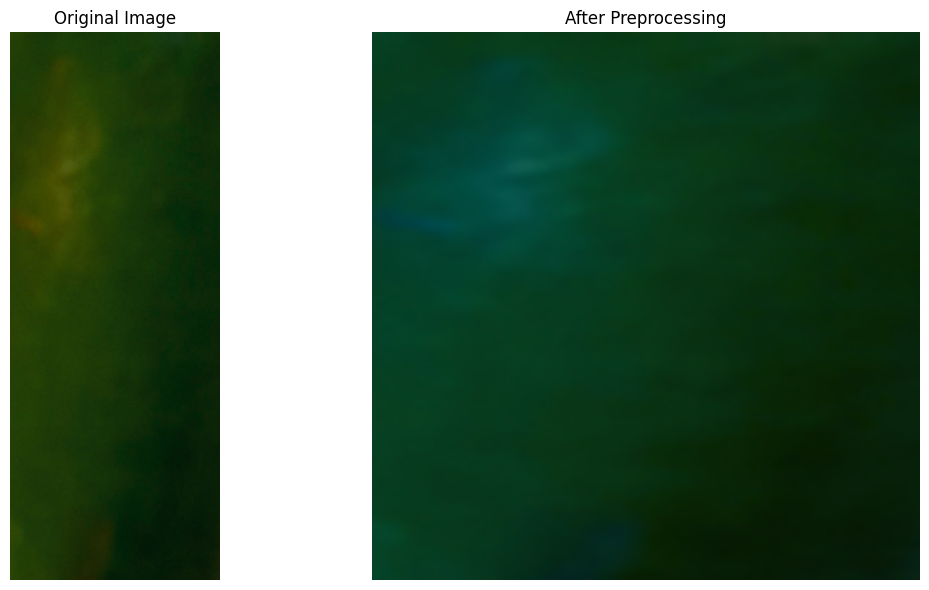

Example preprocessing result for: /content/drive/MyDrive/data/mentah/Pasted image.png


In [14]:
# Function to show preprocessing results
def show_preprocessing_example():
    # Find an example image
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            image_files = glob.glob(os.path.join(class_path, '*.jpg')) + glob.glob(os.path.join(class_path, '*.png'))
            if image_files:
                example_img_path = image_files[0]
                break

    if 'example_img_path' in locals():
        # Load original image
        original_img = cv2.imread(example_img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Apply preprocessing
        processed_img = preprocess_image(example_img_path)

        # Show comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.imshow(original_img)
        ax1.set_title('Original Image')
        ax1.axis('off')

        ax2.imshow(processed_img)
        ax2.set_title('After Preprocessing')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Example preprocessing result for: {example_img_path}")
    else:
        print("Tidak ditemukan file gambar. Pastikan dataset Anda memiliki file .jpg atau .png")

# Show preprocessing example
show_preprocessing_example()

## 3. Pipeline Augmentasi Data

### Implementasi Augmentasi


In [15]:
# Function to apply augmentation and extract features
def augment_and_extract_features(image_path, n_augmented=4):
    """Apply augmentation to a single image and extract features for each augmented version"""
    # Read the original image
    original_img = cv2.imread(image_path)

    # Apply preprocessing to the original image
    processed_img = preprocess_image(image_path)

    # Extract features from original image
    original_features = extract_features(processed_img)
    features_list = [original_features]

    # Create augmented versions
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255  # For augmentation
    )

    # Prepare image for augmentation (needs to be 4D for Keras generator)
    img_array = np.expand_dims(cv2.resize(original_img, (224, 224)), 0)  # Add batch dimension

    # Generate augmented images
    for i in range(n_augmented):
        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0]
        aug_img = (aug_img * 255).astype(np.uint8)  # Convert back to 0-255 range

        # Preprocess the augmented image
        processed_aug_img = preprocess_image_from_array(aug_img)

        # Extract features from the augmented image
        aug_features = extract_features(processed_aug_img)
        features_list.append(aug_features)

    return features_list

# Helper function to preprocess from array instead of file path
def preprocess_image_from_array(img):
    """Fungsi untuk melakukan pra-pemrosesan pada citra dari array"""
    # Terapkan filter Gaussian untuk mengurangi noise
    img_filtered = cv2.GaussianBlur(img, (5, 5), 0)

    # Konversi ke ruang warna HSV untuk segmentasi
    hsv = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2HSV)

    # Thresholding sederhana untuk memisahkan papaya dari latar belakang
    lower_hsv = np.array([0, 20, 20])
    upper_hsv = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # Terapkan mask untuk mendapatkan citra yang disegmentasi
    segmented = cv2.bitwise_and(img_filtered, img_filtered, mask=mask)

    return segmented

# Visualize augmented images
def visualize_augmentation(image_path):
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Create augmented versions
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255
    )

    img_array = np.expand_dims(cv2.resize(original_img, (224, 224)), 0)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    for i in range(1, 6):
        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0]
        aug_img = (aug_img * 255).astype(np.uint8)

        row = i // 3
        col = i % 3

        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f'Augmented {i}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

### Contoh Hasil Augmentasi dan jumlah



Augmentation example for mentah class:


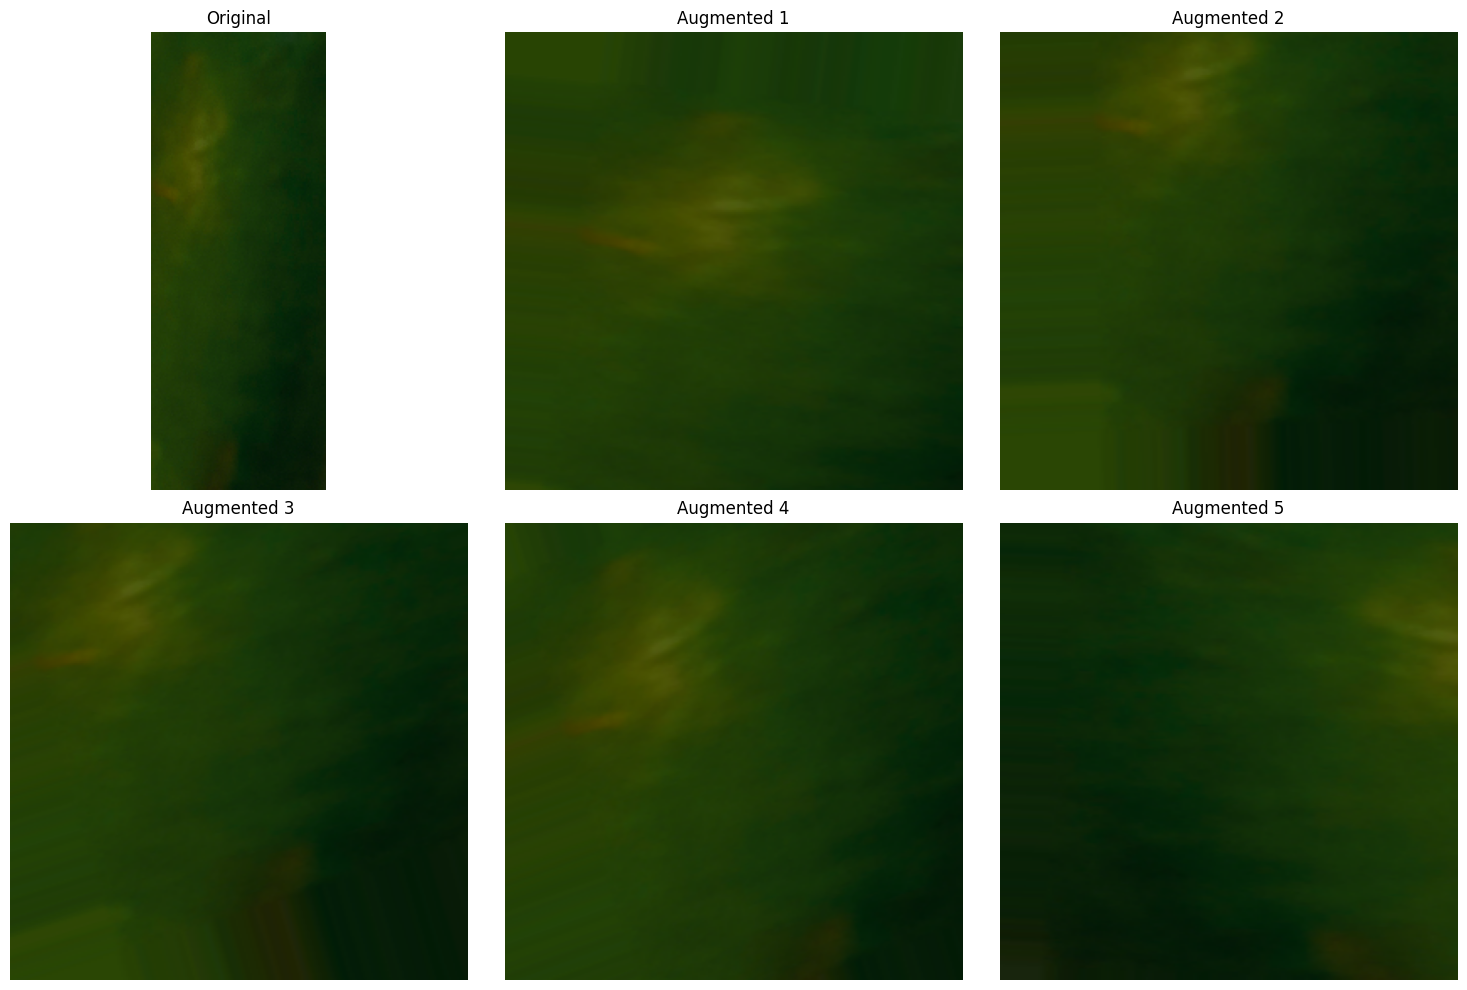

Augmentation results:
matang: 11 -> 55 images (augmented)
mentah: 11 -> 55 images (augmented)
setengah: 11 -> 55 images (augmented)
Total images after augmentation: 165


In [27]:
# Show augmentation example
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        image_files = glob.glob(os.path.join(class_path, '*.jpg')) + glob.glob(os.path.join(class_path, '*.png'))
        if image_files:
            example_img_path = image_files[0]
            print(f"Augmentation example for {class_name} class:")
            visualize_augmentation(example_img_path)
            break

# Calculate actual augmented data size
augmented_counts = {}
unique_labels, counts = np.unique(y, return_counts=True)
for label, count in zip(unique_labels, counts):
    augmented_counts[label] = count

print("Augmentation results:")
for class_name, count in augmented_counts.items():
    original_count = initial_counts[class_name]
    print(f"{class_name}: {original_count} -> {count} images (augmented)")

total_augmented = sum(augmented_counts.values())
print(f"Total images after augmentation: {total_augmented}")

## 4. Ekstraksi Ciri Warna (Statistik RGB dan HSV)

### Ekstraksi Fitur Warna


In [17]:
# Function to extract comprehensive color features (RGB and HSV histogram statistics)
def extract_features(image):
    """Fungsi untuk mengekstrak fitur warna dari citra"""
    # Hitung nilai rata-rata RGB
    mean_r = np.mean(image[:,:,2])  # R channel
    mean_g = np.mean(image[:,:,1])  # G channel
    mean_b = np.mean(image[:,:,0])  # B channel

    # Hitung variansi RGB
    var_r = np.var(image[:,:,2])
    var_g = np.var(image[:,:,1])
    var_b = np.var(image[:,:,0])

    # Konversi ke HSV dan hitung nilai rata-rata
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_h = np.mean(hsv[:,:,0])  # Hue
    mean_s = np.mean(hsv[:,:,1])  # Saturation
    mean_v = np.mean(hsv[:,:,2])  # Value

    # Hitung variansi HSV
    var_h = np.var(hsv[:,:,0])
    var_s = np.var(hsv[:,:,1])
    var_v = np.var(hsv[:,:,2])

    # Hitung median RGB dan HSV
    median_r = np.median(image[:,:,2])
    median_g = np.median(image[:,:,1])
    median_b = np.median(image[:,:,0])
    median_h = np.median(hsv[:,:,0])
    median_s = np.median(hsv[:,:,1])
    median_v = np.median(hsv[:,:,2])

    # Kembalikan fitur sebagai array - menggunakan hanya nilai rata-rata sesuai permintaan
    # Menggunakan nilai rata-rata R,G,B,H,S,V sebagai fitur
    features = [mean_r, mean_g, mean_b, mean_h, mean_s, mean_v]
    return features

## 5. Proses Muat dan Augmentasi Data


In [18]:
# Muat dan proses semua citra dengan data preprocessing dan augmentation
features_list = []
labels_list = []

# Proses untuk setiap kelas (mentah, setengah, matang)
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    print(f"Memproses kelas: {class_name}")

    # Cek apakah path kelas ada
    if os.path.exists(class_path):
        # Ambil semua file gambar dengan ekstensi tertentu
        image_extensions = ['*.jpg', '*.jpeg', '*.png']
        image_files = []

        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(class_path, ext)))

        print(f"  Menemukan {len(image_files)} citra")

        # Proses setiap citra
        for img_path in image_files:
            try:
                # Extract features from original and augmented images
                img_features_list = augment_and_extract_features(img_path, n_augmented=4)

                # Add original and augmented features with corresponding labels
                for features in img_features_list:
                    features_list.append(features)
                    labels_list.append(class_name)
            except Exception as e:
                print(f"  Gagal memproses {img_path}: {str(e)}")
                continue
    else:
        print(f"  Path tidak ditemukan: {class_path}")

# Konversi ke array numpy
X = np.array(features_list)
y = np.array(labels_list)

print(f"\nDataset berhasil diproses!")
print(f"Ukuran dataset: {X.shape}")
print(f"Jumlah sampel per kelas: {np.unique(y, return_counts=True)}")

Memproses kelas: mentah
  Menemukan 11 citra
Memproses kelas: setengah
  Menemukan 11 citra
Memproses kelas: matang
  Menemukan 11 citra

Dataset berhasil diproses!
Ukuran dataset: (165, 6)
Jumlah sampel per kelas: (array(['matang', 'mentah', 'setengah'], dtype='<U8'), array([55, 55, 55]))


## 6. Pelatihan Model SVM dengan Data yang Di-augmentasi

### Pembuatan dan Pelatihan Model SVM


In [28]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Pisahkan dataset menjadi data pelatihan dan pengujian (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Ukuran data pelatihan: {X_train.shape}")
print(f"Ukuran data pengujian: {X_test.shape}")
print(f"Kelas: {label_encoder.classes_}")

# Buat dan latih model SVM
svm_model = svm.SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

print("Model SVM selesai dilatih")

Ukuran data pelatihan: (132, 6)
Ukuran data pengujian: (33, 6)
Kelas: ['matang' 'mentah' 'setengah']
Model SVM selesai dilatih


## 7. Evaluasi Model

### Metrik Evaluasi Komprehensif dan Matriks Confusion



Accuracy: 0.9394
F1-Score: 0.9389
Recall: 0.9394
Precision: 0.9487

Detailed Classification Report:
              precision    recall  f1-score   support

      matang       0.85      1.00      0.92        11
      mentah       1.00      1.00      1.00        11
    setengah       1.00      0.82      0.90        11

    accuracy                           0.94        33
   macro avg       0.95      0.94      0.94        33
weighted avg       0.95      0.94      0.94        33



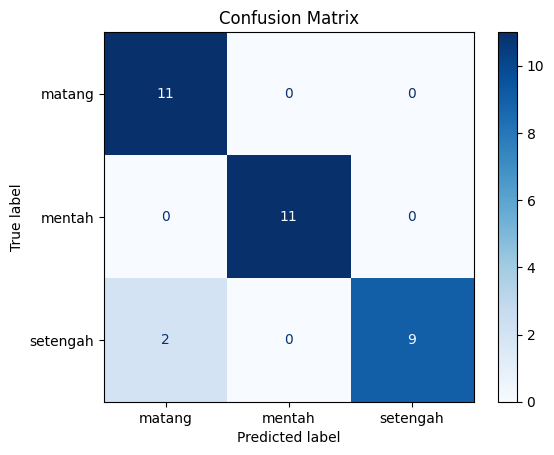

In [29]:
# Lakukan prediksi
y_pred = svm_model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
target_names = label_encoder.classes_
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()